In [1]:
from bindingcalculator import BindingCalculator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Mutation level analysis

In [118]:
# instantiate binding calculator based on escape data
# https://github.com/jbloomlab/SARS2_RBD_Ab_escape_maps/
bindcalc = BindingCalculator(csv_or_url='./escape_calculator_data.csv',
                             eliciting_virus='SARS-CoV-2',
                             source_lab='all',
                             neutralizes_Omicron='either',
                             #metric='sum of mutations at site',
                             metric='mean of mutations at site',
                             mutation_escape_strength=2.0)
sites = bindcalc.sites
print("A total of {} RBD sites have escape data".format(len(bindcalc.sites)))

A total of 201 RBD sites have escape data


In [127]:
# ingest pyro-cov inferences
mutations = pd.read_csv('../paper/mutations.tsv', sep='\t')
# filter to S gene only
mutations = mutations[[m[:2]=='S:' for m in mutations.mutation]]
print("Our model considers {} mutations in the S gene.".format(len(mutations)))
# filter to sites that we have escape data for
mutations = mutations[[int(m[3:-1]) in sites for m in mutations.mutation]]
sites = [int(m[3:-1]) if int(m[3:-1]) in sites else None for m in mutations.mutation]
print("Of these, {} mutations have escape data:".format(len(sites)))
print(sites)

Our model considers 321 mutations in the S gene.
Of these, 41 mutations have escape data:
[484, 501, 452, 477, 417, 478, 490, 439, 452, 484, 440, 501, 520, 346, 494, 478, 522, 346, 449, 414, 411, 484, 450, 452, 385, 479, 446, 486, 357, 481, 477, 384, 445, 483, 382, 493, 522, 408, 477, 453, 417]


In [4]:
#binding = [-np.log(bindcalc.binding_retained([s])) for s in sites]
binding = np.array([1 - bindcalc.binding_retained([s]) for s in sites])
inferred_log_growth = mutations['Δ log R'].values
#inferred_log_growth = inferred_log_growth[binding > 0.03]
#binding = binding[binding > 0.03]

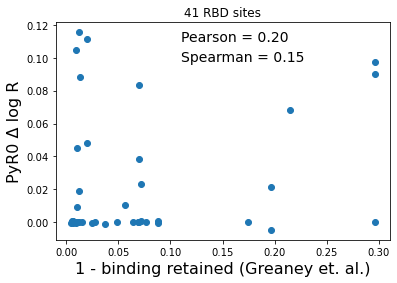

In [5]:
pearson = stats.pearsonr(binding, inferred_log_growth)[0]
spearman = stats.spearmanr(binding, inferred_log_growth)[0]

plt.scatter(binding, inferred_log_growth)
plt.xlabel("1 - binding retained (Greaney et. al.)", fontsize=16)
plt.ylabel("PyR0 Δ log R", fontsize=16)
plt.text(0.11, 0.11, "Pearson = {:.2f}".format(pearson), fontsize=14)
plt.text(0.11, 0.098, "Spearman = {:.2f}".format(spearman), fontsize=14)
plt.title("{} RBD sites".format(len(binding)))
plt.show()

## Variant level analysis

In [6]:
def compute_agg_logR(variant):
    logR = 0.0
    for m in variant:
        logRs = mutations[[int(x[3:-1])==m for x in mutations.mutation]]['Δ log R'].values
        # TODO: use actual mutation in variant not mean
        logR += 0.0 if len(logRs) == 0 else logRs.mean()
    return logR

In [7]:
omicron = [339, 371, 373, 375, 417, 440, 446, 477, 478, 484, 493, 496, 498, 501, 505]
alpha = [501]
betagamma = [417, 484, 501]  # beta == gamma at rbd
delta = [452, 478]
lambd = [452, 490]
mu = [346, 484, 501] 
variants = [omicron, alpha, betagamma, delta, lambd, mu]
names = ['omicron', 'alpha', 'beta/gamma', 'delta', 'lambda', 'mu']

In [8]:
pyro_logR = [compute_agg_logR(variant) for variant in variants]
binding = [1 - bindcalc.binding_retained(variant) for variant in variants]

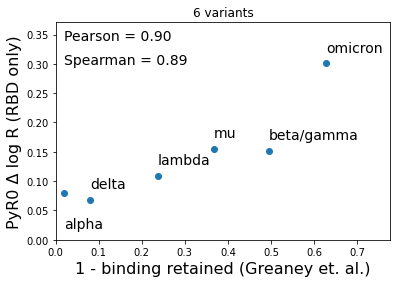

In [9]:
pearson = stats.pearsonr(binding, pyro_logR)[0]
spearman = stats.spearmanr(binding, pyro_logR)[0]

plt.scatter(binding, pyro_logR)
plt.xlabel("1 - binding retained (Greaney et. al.)", fontsize=16)
plt.ylabel("PyR0 Δ log R (RBD only)", fontsize=16)
plt.text(0.02, 0.34, "Pearson = {:.2f}".format(pearson), fontsize=14)
plt.text(0.02, 0.30, "Spearman = {:.2f}".format(spearman), fontsize=14)
plt.title("{} variants".format(len(binding)))
plt.ylim(0.0, max(pyro_logR) + 0.07)
plt.xlim(0.0, max(binding) + 0.15)

for i in range(len(binding)):
    adjust = -0.08 if names[i] == 'alpha' else 0.0
    plt.annotate(names[i], (binding[i], pyro_logR[i]+0.02+adjust), fontsize=14)
    
plt.show()

## Compare RBD to non-RBD

In [68]:
variants = [omicron, alpha, betagamma, betagamma, delta, lambd, mu][1:]
names = ['omicron', 'alpha', 'beta', 'gamma', 'delta', 'lambda', 'mu'][1:]
pyro_names = ['B.1.1.529', 'B.1.1.7', 'B.1.351', 'P.1', 'B.1.617.2', 'C.37', 'B.1.621'][1:]
pyro_rbd_logR = [compute_agg_logR(variant) for variant in variants]
assert len(names) == len(pyro_names) == len(pyro_rbd_logR)

In [69]:
strains = pd.read_csv('../paper/strains.tsv', sep='\t')[['strain', 'R / R_A']]

In [70]:
pyro_nonrbd_logR = []

for name, rbd_logR in zip(pyro_names, pyro_rbd_logR):
    x = np.log(strains[strains.strain == name].values[0, 1]) - rbd_logR
    pyro_nonrbd_logR.append(x)

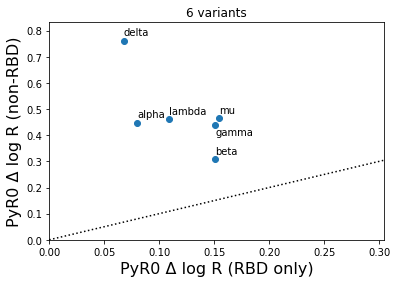

In [83]:
plt.scatter(pyro_rbd_logR, pyro_nonrbd_logR)
plt.xlabel("PyR0 Δ log R (RBD only)", fontsize=16)
plt.ylabel("PyR0 Δ log R (non-RBD)", fontsize=16)
#plt.text(0.02, 0.34, "Pearson = {:.2f}".format(pearson), fontsize=14)
#plt.text(0.02, 0.30, "Spearman = {:.2f}".format(spearman), fontsize=14)
plt.title("{} variants".format(len(binding)))
plt.ylim(0.0, max(pyro_nonrbd_logR) + 0.07)
plt.xlim(0.0, max(pyro_rbd_logR) + 0.15)
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), ls='dotted', color='k')


for i in range(len(pyro_nonrbd_logR)):
    adjust = -0.06 if names[i] == 'gamma' else 0.0
    plt.annotate(names[i], (pyro_rbd_logR[i], pyro_nonrbd_logR[i]+0.02+adjust), 
                 fontsize=10)
    
plt.show()

## Compare RBD contribution to birthday

In [74]:
strains = pd.read_csv('../paper/strains.tsv', sep='\t')[['strain', 'R / R_A', 'birthday']]

In [75]:
strains

,strain,R / R_A,birthday
0,AY.4.2.1,2.799510,2021-07-29
1,AY.4.2,2.765840,2021-06-18
2,AY.108,2.646720,2021-07-01
3,AY.109,2.640450,2021-07-13
4,AY.111,2.633520,2021-04-21
...,...,...,...
1477,B.61,0.836487,2020-03-04
1478,B.60,0.836430,2020-03-20
1479,B.41,0.836298,2020-02-19
1480,B.33,0.835864,2020-03-01


In [12]:
rbd_min = min(bindcalc.sites)
rbd_max = max(bindcalc.sites)
print("Assuming RBD spans {} to {}".format(rbd_min, rbd_max))

Assuming RBD spans 331 to 531


In [21]:
all_mutations = pd.read_csv('../paper/mutations.tsv', sep='\t')
# filter to RBD mutations in S gene only
rbd_mutations = all_mutations[[m[:2]=='S:' and int(m[3:-1]) >= rbd_min and int(m[3:-1]) <= rbd_max
                               for m in all_mutations.mutation]]

In [22]:
#rbd_mutations = rbd_mutations[['mutations', 'Δ log R']]

In [73]:
strains = pd.read_csv('../paper/strains.tsv', sep='\t') #[['strain', 'R / R_A']]
strains

,rank,strain,mean/stddev,log10(P(R > R_A)),R / R_A,R / R_A 95% ci lower,R / R_A 95% ci upper,confirmed cases / day,confirmed cases total,birthday,mutations
0,1,AY.4.2.1,105.3620,2413.0100,2.799510,2.743140,2.857050,4.225860e+03,317709.000,2021-07-29,"S:D614G,ORF1b:P314L"
1,2,AY.4.2,67.9417,1004.6000,2.765840,2.680870,2.853490,2.949410e+04,2089930.000,2021-06-18,"S:D614G,ORF1b:P314L"
2,3,AY.108,13.6959,42.2702,2.646720,2.281530,3.070370,1.157560e+04,4436720.000,2021-07-01,"ORF3a:G251V,ORF1a:M1769I"
3,4,AY.109,15.9362,56.7503,2.640450,2.324810,2.998950,3.531190e+04,4723280.000,2021-07-13,ORF3a:G251V
4,5,AY.111,33.1879,241.0940,2.633520,2.477730,2.799100,1.299510e+03,207357.000,2021-04-21,ORF1b:A88V
...,...,...,...,...,...,...,...,...,...,...,...
1477,1478,B.61,-16.1044,-57.9249,0.836487,0.824928,0.848209,7.828620e-24,3431.590,2020-03-04,"S:D614G,ORF1b:P314L,N:R203K,S:N501Y,S:P681H,OR..."
1478,1479,B.60,-27.2831,-163.4730,0.836430,0.829584,0.843332,5.763260e-32,935.565,2020-03-20,"S:D614G,ORF1b:P314L,N:R203K,S:N501Y,S:P681H,OR..."
1479,1480,B.41,-24.8499,-135.8870,0.836298,0.828775,0.843888,1.122870e-22,3521.290,2020-02-19,"S:D614G,ORF1b:P314L,N:R203K,S:N501Y,S:P681H,S:..."
1480,1481,B.33,-11.6205,-30.7904,0.835864,0.819796,0.852247,4.021840e-12,153783.000,2020-03-01,"S:D614G,ORF1b:P314L,N:R203K,N:G204R,S:N501Y,S:..."


In [123]:
escape = bindcalc.escape_data
escape = escape[escape.virus=='SARS-CoV-2']
#escape = escape[escape.metric=='sum of mutations at site']
#escape = escape[escape.metric=='mean of mutations at site']

In [143]:
mean_escape = []

for site in sites:
    df = escape[escape.site == site]
    mean_escape.append(df.escape.max())
    
print(len(inferred_log_growth))
print(len(mean_escape))

41
41


0.05532522709938673 0.16396046648697138


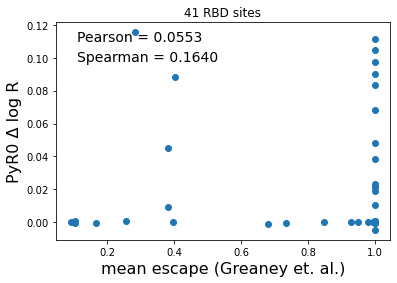

In [144]:
pearson = stats.pearsonr(mean_escape, inferred_log_growth)[0]
spearman = stats.spearmanr(mean_escape, inferred_log_growth)[0]
print(pearson, spearman)

plt.scatter(mean_escape, inferred_log_growth)
plt.xlabel("mean escape (Greaney et. al.)", fontsize=16)
plt.ylabel("PyR0 Δ log R", fontsize=16)
plt.text(0.11, 0.11, "Pearson = {:.4f}".format(pearson), fontsize=14)
plt.text(0.11, 0.098, "Spearman = {:.4f}".format(spearman), fontsize=14)
plt.title("{} RBD sites".format(len(mean_escape)))
plt.show()

In [109]:
escape

,condition,virus,Omicron,lab,site,metric,escape,max_escape,scale_escape
0,BD-739,SARS-CoV-2,False,Xie_XS,331,sum of mutations at site,0.000000,1.0,0.000000
1,BD-739,SARS-CoV-2,False,Xie_XS,332,sum of mutations at site,0.000000,1.0,0.000000
2,BD-739,SARS-CoV-2,False,Xie_XS,333,sum of mutations at site,0.000000,1.0,0.000000
3,BD-739,SARS-CoV-2,False,Xie_XS,334,sum of mutations at site,0.000000,1.0,0.000000
4,BD-739,SARS-CoV-2,False,Xie_XS,335,sum of mutations at site,0.000000,1.0,0.000000
...,...,...,...,...,...,...,...,...,...
56878,S2X259,SARS-CoV-2,False,Bloom_JD,527,sum of mutations at site,0.001818,1.0,0.001818
56879,S2X259,SARS-CoV-2,False,Bloom_JD,528,sum of mutations at site,0.001819,1.0,0.001819
56880,S2X259,SARS-CoV-2,False,Bloom_JD,529,sum of mutations at site,0.002107,1.0,0.002107
56881,S2X259,SARS-CoV-2,False,Bloom_JD,530,sum of mutations at site,0.002142,1.0,0.002142
